In [19]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab inline
import pandas as pd
import json
import seaborn
import copy
import os
from Chapter2.CreateDataset import CreateDataset
from util.VisualizeDataset import VisualizeDataset
from Chapter3.OutlierDetection import DistributionBasedOutlierDetection
from Chapter3.OutlierDetection import DistanceBasedOutlierDetection
from Chapter3.DataTransformation import LowPassFilter
from Chapter3.DataTransformation import PrincipalComponentAnalysis
from Chapter3.ImputationMissingValues import ImputationMissingValues
from Chapter3.KalmanFilters import KalmanFilters
from util.VisualizeDataset import VisualizeDataset
from util import util
from util.parser import get_labels,generate_csv,generate_labels,get_sensor_values
import time

Populating the interactive namespace from numpy and matplotlib


# Below cell has global variables (path-names mostly)

In [2]:
dataset_folder = './datasets'
files = os.listdir(dataset_folder)
print(files)
dataset_fname  = 'log_assignment3'
event_fname = 'log_events_assignment3'
result_dataset_path = './intermediate_datafiles/'
csv_dataset_path = os.path.join(dataset_folder,'csv/')
dataset_path = os.path.join(dataset_folder,dataset_fname)
event_path = os.path.join(dataset_folder,event_fname)
output_fname = 'dataset.csv'

['log_assignment2', 'log_events_assignment3', 'log_assignment3', 'csv', 'log_events_assignment2']


In [3]:
if not os.path.exists(result_dataset_path):
    print('Creating result directory: ' + result_dataset_path)
    os.makedirs(result_dataset_path)
if not os.path.exists(csv_dataset_path):
    print('Creating result directory: ' + csv_dataset_path)
    os.makedirs(csv_dataset_path)

### LOG PARSING FUNCTION CALL

In [4]:
labels = get_labels(dataset_path)
print('Label Mappings:\n')
print(json.dumps(labels,indent=2))


Label Mappings:

{
  "stairsdown": [
    1, 
    3, 
    5, 
    7, 
    9, 
    11
  ], 
  "stairsup": [
    2, 
    4, 
    6, 
    8, 
    10, 
    12
  ], 
  "walking": [
    13
  ]
}


In [5]:
sensors_dict = get_sensor_values(dataset_path)
print('Sensors in log file')
sensors = sensors_dict.keys()
print(json.dumps(sensors,indent=2))

Sensors in log file
[
  "bmi160 accelerometer", 
  "bmi160 gyroscope", 
  "rotation vector"
]


# CSV generation cell

In [6]:
for sensor in sensors:
    if sensor == 'rotation vector':
        generate_csv(sensors_dict[sensor],
                     header=['x','y','z','theta','phi','timestamp'],
                     fname = os.path.join(csv_dataset_path,sensor+'.csv'))
    else:
        generate_csv(sensors_dict[sensor],fname = os.path.join(csv_dataset_path,sensor+'.csv'))
generate_labels(fname=event_path,log_fname=dataset_path,fout=csv_dataset_path+'labels.csv');

# Dataset creation cell

In [7]:
granularities = [250,1000,10000]
datasets = []


for milliseconds_per_instance in granularities:
    initial = time.time()
    # Create an initial dataset object with the base directory for our data and a granularity
    DataSet = CreateDataset(csv_dataset_path, milliseconds_per_instance)
    print('granularity is %d ms'%milliseconds_per_instance)
    
    DataSet.add_numerical_dataset('bmi160 accelerometer.csv','timestamp',['x','y','z'],'avg','acc_phone_')
    DataSet.add_numerical_dataset('bmi160 gyroscope.csv','timestamp',['x','y','z'],'avg','gyr_phone_')
    DataSet.add_numerical_dataset('rotation vector.csv','timestamp',['x','y','z','theta','phi'],'avg','rotation_phone_')
    DataSet.add_event_dataset('labels.csv','label_start','label_end','label','binary')
    print('Added all sensors and labels')
    dataset = DataSet.data_table
#     util.print_statistics(dataset)
    datasets.append(copy.deepcopy(dataset))
    dataset.to_csv(result_dataset_path + '/'+str(milliseconds_per_instance)+ '_dataset.csv')
    print('Dataset created,\tDuration:%.5f seconds'%(time.time()-initial))
    print('====================================')
    


granularity is 250 ms
Added all sensors and labels
Dataset created,	Duration:13.23647 seconds
granularity is 1000 ms
Added all sensors and labels
Dataset created,	Duration:4.81268 seconds
granularity is 10000 ms
Added all sensors and labels
Dataset created,	Duration:1.62696 seconds


# Some visualizations

In [13]:
DataViz = VisualizeDataset()
# rcParams['figure.figsize'] = (20,10)
# for i in range(len(datasets)):
#     DataViz.plot_dataset(datasets[i],['acc_phone'],['like'],['line'])
#     DataViz.plot_dataset(datasets[i],['gyr_phone'],['like'],['line'])
#     DataViz.plot_dataset(datasets[i],['rotation_phone'],['like'],['line'])
# #     DataViz.plot_dataset(datasets[i],['label'],['like'],['points','points'])

# Data Filtering Cell

In [10]:
### choose a dataset to filter:
data_index = 0
dataset = datasets[data_index] # minimum granularity - biggest dataset
millis = granularities[data_index]
dataset.index = pd.to_datetime(dataset.index)
milliseconds_per_instance = (dataset.index[1] - dataset.index[0]).microseconds/1000
print("Using milliseconds per instance: %d"%milliseconds_per_instance)
outlier_columns = ['acc_phone_x', 'gyr_phone_y']
# dataset.head()

Using milliseconds per instance: 250


util/VisualizeDataset.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_table[outlier_col] = data_table[outlier_col].astype('bool')


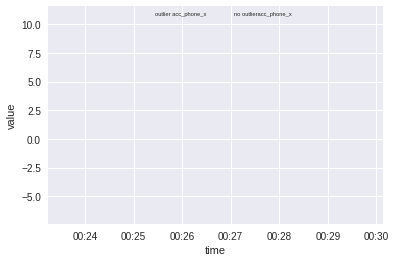

/home/cts/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/cts/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/cts/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/cts/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: Depr

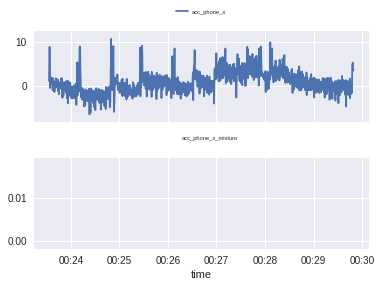

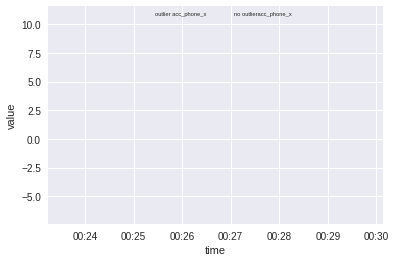

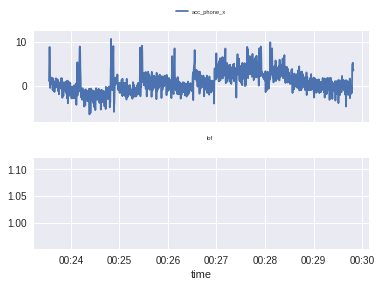

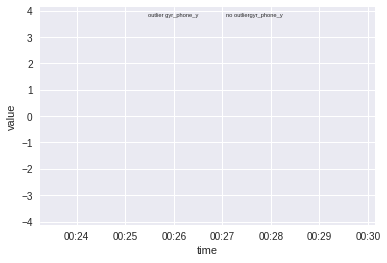

/home/cts/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/cts/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/cts/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/cts/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: Depr

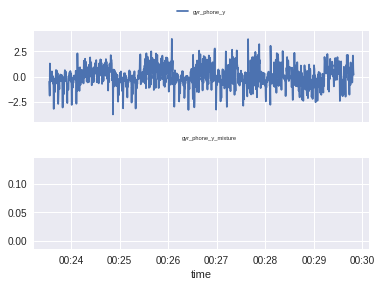

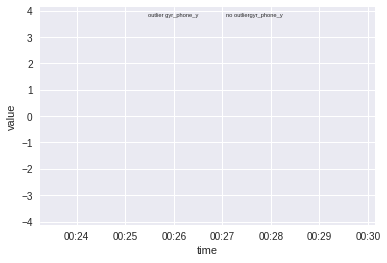

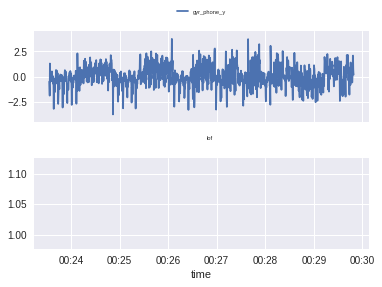

In [17]:
OutlierDistr = DistributionBasedOutlierDetection()
OutlierDist = DistanceBasedOutlierDetection()

#And investigate the approaches for all relevant attributes.
for col in outlier_columns:
    # And try out all different approaches. Note that we have done some optimization
    # of the parameter values for each of the approaches by visual inspection.
    dataset = OutlierDistr.chauvenet(dataset, col)
    DataViz.plot_binary_outliers(dataset, col, col + '_outlier')
    dataset = OutlierDistr.mixture_model(dataset, col)
    DataViz.plot_dataset(dataset, [col, col + '_mixture'], ['exact','exact'], ['line', 'points'])
    # This requires:
    # n_data_points * n_data_points * point_size =
    # 31839 * 31839 * 64 bits = ~8GB available memory
    try:
        dataset = OutlierDist.simple_distance_based(dataset, [col], 'euclidean', 0.10, 0.99)
        DataViz.plot_binary_outliers(dataset, col, 'simple_dist_outlier')
    except MemoryError as e:
        print('Not enough memory available for simple distance-based outlier detection...')
        print('Skipping.')
    
    try:
        dataset = OutlierDist.local_outlier_factor(dataset, [col], 'euclidean', 5)
        DataViz.plot_dataset(dataset, [col, 'lof'], ['exact','exact'], ['line', 'points'])
    except MemoryError as e:
        print('Not enough memory available for lof...')
        print('Skipping.')

    # Remove all the stuff from the dataset again.
    cols_to_remove = [col + '_outlier', col + '_mixture', 'simple_dist_outlier', 'lof']
    for to_remove in cols_to_remove:
        if to_remove in dataset:
            del dataset[to_remove]

# We take Chauvent's criterion and apply it to all but the label data...

for col in [c for c in dataset.columns if not 'label' in c]:
#     print('Measurement is now: ' , col)
    dataset = OutlierDistr.chauvenet(dataset, col)
    dataset.loc[dataset[col + '_outlier'] == True, col] = np.nan
    del dataset[col + '_outlier']
dataset.to_csv(result_dataset_path +str(millis)+'_outlier.csv')

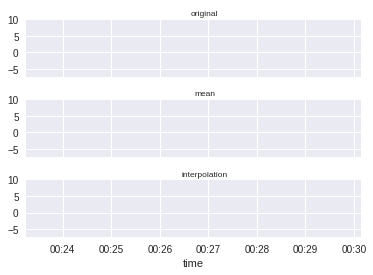

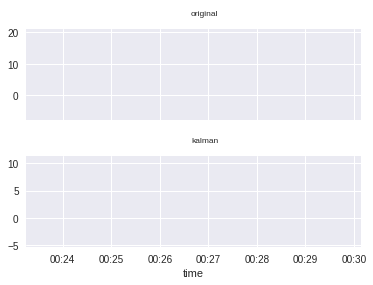

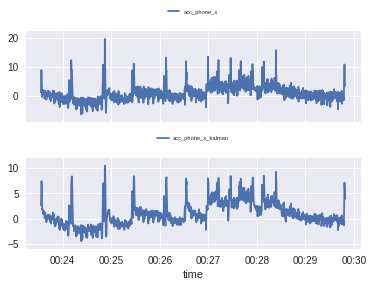

In [23]:
miss_value = 'rotation_phone_theta'
MisVal = ImputationMissingValues()
imputed_mean_dataset = MisVal.impute_mean(copy.deepcopy(dataset), miss_value)
imputed_median_dataset = MisVal.impute_median(copy.deepcopy(dataset), miss_value)
imputed_interpolation_dataset = MisVal.impute_interpolate(copy.deepcopy(dataset), miss_value)
DataViz.plot_imputed_values(dataset, ['original', 'mean', 'interpolation'], 
                            miss_value, imputed_mean_dataset[miss_value], imputed_interpolation_dataset[miss_value])

# And we impute for all columns except for the label in the selected way (interpolation)

for col in [c for c in dataset.columns if not 'label' in c]:
    dataset = MisVal.impute_interpolate(dataset, col)

# Let us try the Kalman filter on the light_phone_lux attribute and study the result.

original_dataset = pd.read_csv(result_dataset_path+str(millis)+'_dataset.csv',index_col=0)
original_dataset.index = pd.to_datetime(original_dataset.index)
KalFilter = KalmanFilters()

kalman_dataset = KalFilter.apply_kalman_filter(original_dataset, 'acc_phone_x')
DataViz.plot_imputed_values(kalman_dataset, ['original', 'kalman'], 'acc_phone_x', kalman_dataset['acc_phone_x_kalman'])
DataViz.plot_dataset(kalman_dataset, ['acc_phone_x', 'acc_phone_x_kalman'], ['exact','exact'], ['line', 'line'])